In [24]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('heart_num_0228.csv')
data.columns

Index(['State', 'Sex', 'GeneralHealth', 'PhysicalHealthDays',
       'MentalHealthDays', 'LastCheckupTime', 'PhysicalActivities',
       'SleepHours', 'RemovedTeeth', 'HadHeartAttack', 'HadAngina',
       'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD',
       'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis',
       'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
       'ECigaretteUsage', 'ChestScan', 'AgeCategory', 'HeightInMeters',
       'WeightInKilograms', 'BMI', 'AlcoholDrinkers', 'HIVTesting',
       'FluVaxLast12', 'PneumoVaxEver', 'HighRiskLastYear', 'CovidPos',
       'RaceEthnicityCategory_Black only, Non-Hispanic',
       'RaceEthnicityCategory_Hispanic',
       'RaceEthnicityCategory_Multiracial, Non-Hispanic',
       'RaceEthnicityCategory_Other race only, Non-Hispanic',
       'RaceEthnicityCategory_White only, N

In [4]:
Q1 = data[['SleepHours', 'BMI']].quantile(q = 0.25)
Q3 = data[['SleepHours', 'BMI']].quantile(q = 0.75)
IQR = Q3-Q1
data_iqr = data[(data['SleepHours'] <= Q3['SleepHours']+IQR['SleepHours']*1.5)&(data['SleepHours'] >= Q1['SleepHours']-IQR['SleepHours']*1.5)]
data_iqr = data_iqr[(data_iqr['BMI'] <= Q3['BMI']+IQR['BMI']*1.5)&(data_iqr['BMI'] >= Q1['BMI']-IQR['BMI']*1.5)]
print('Original data:', len(data))
print('Remove Outlier data:', len(data_iqr))

Original data: 274034
Remove Outlier data: 261812


In [6]:
data_iqr['LungDisease'] = 0
data_iqr.loc[data_iqr['HadAsthma'] == 1, 'LungDisease'] = 1
data_iqr.loc[data_iqr['HadCOPD'] == 1, 'LungDisease'] = 1
print(len(data_iqr[data_iqr['LungDisease'] == 1]))
print(len(data_iqr[data_iqr['LungDisease'] == 0]))

50187
211625


In [7]:
X = data_iqr.drop(['LungDisease', 'HadAsthma', 'HadCOPD'], axis = 1)
y = data_iqr['LungDisease']

In [8]:
from imblearn.over_sampling import SMOTE

In [9]:
smo = SMOTE(random_state = 1234)
X_re, y_re = smo.fit_resample(X, y)
print('Original Data:', len(X))
print('Resampled Data:', len(X_re))

Original Data: 261812
Resampled Data: 423250


In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_re, y_re, test_size = 0.2, random_state = 1234)

In [12]:
from sklearn.preprocessing import RobustScaler

In [13]:
rbs = RobustScaler()
X_trn = rbs.fit_transform(X_train)
X_tst = rbs.transform(X_test)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.callbacks import EarlyStopping

In [16]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [15]:
print(X_trn.shape)

(338600, 45)


In [17]:
es = EarlyStopping(monitor = 'accuracy')

model = Sequential()
model.add(Dense(50, input_dim = 45, activation = 'relu'))
model.add(Dense(28, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy', f1_m, precision_m, recall_m])
history = model.fit(X_trn, y_train, epochs = 100, batch_size = 10, callbacks = [es])



Epoch 1/100


33860/33860 [==============================] - 57s 2ms/step - loss: 0.3766 - accuracy: 0.8218 - f1_m: 0.7789 - precision_m: 0.9015 - recall_m: 0.7184
Epoch 2/100
33860/33860 [==============================] - 58s 2ms/step - loss: 0.3507 - accuracy: 0.8383 - f1_m: 0.8002 - precision_m: 0.9150 - recall_m: 0.7411
Epoch 3/100
33860/33860 [==============================] - 68s 2ms/step - loss: 0.3397 - accuracy: 0.8451 - f1_m: 0.8085 - precision_m: 0.9230 - recall_m: 0.7485
Epoch 4/100
33860/33860 [==============================] - 82s 2ms/step - loss: 0.3354 - accuracy: 0.8477 - f1_m: 0.8113 - precision_m: 0.9251 - recall_m: 0.7510
Epoch 5/100
33860/33860 [==============================] - 84s 2ms/step - loss: 0.3318 - accuracy: 0.8502 - f1_m: 0.8150 - precision_m: 0.9280 - recall_m: 0.7545
Epoch 6/100
33860/33860 [==============================] - 80s 2ms/step - loss: 0.3289 - accuracy: 0.8521 - f1_m: 0.8174 - precision_m: 0.9300 - recall_m: 0.7572
Epoch 7/100
33860/33860 

In [18]:
loss, acc, f1, precision, recall = model.evaluate(X_trn, y_train)
print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc*100:.2f}%')
print(f'F1 Score: {f1:.4f}')

10582/10582 [==============================] - 13s 1ms/step - loss: 0.3061 - accuracy: 0.8653 - f1_m: 0.8454 - precision_m: 0.9623 - recall_m: 0.7612
Loss: 0.3061
Accuracy: 86.53%
F1 Score: 0.8454


In [23]:
y_loss = history.history['loss']
y_acc = history.history['accuracy']
y_f1 = history.history['f1_m']

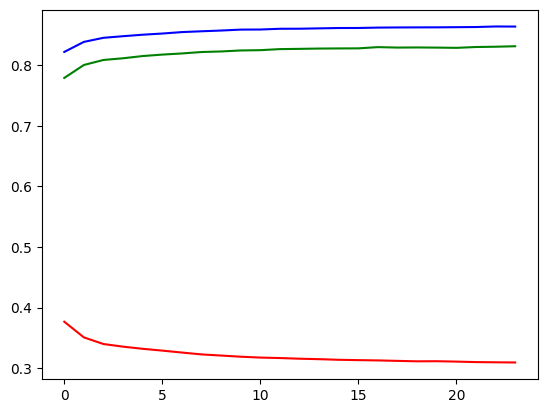

In [26]:
x_len = np.arange(len(y_acc))

plt.plot(x_len, y_loss,  c = 'red', markersize = 3)
plt.plot(x_len, y_acc, c = 'blue', markersize = 3)
plt.plot(x_len, y_f1, c = 'green', markersize = 3)
plt.show()